# Obtaining data for MA-DPG evaluation form example 02b


In [1]:
# Module imports
import os
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sqlalchemy import create_engine

# assume module imports
import examples.examples as examples
from assume import World
from assume.scenario.loader_csv import (
    load_file,
    load_scenario_folder,
    run_learning,
)

## 1. Running example 02b

In [2]:
example = "small_learning_2"
db_uri = "sqlite:///../local_db/assume_db.db"
inputs_dir = "../inputs"

scenario = examples.available_examples[example]["scenario"]
study_case = examples.available_examples[example]["study_case"]
csv_path = "outputs/" + scenario + "/" + study_case

In [3]:
# Run example 02b
world = World(database_uri=db_uri, export_csv_path=csv_path)
load_scenario_folder(world, inputs_dir, scenario, study_case)
run_learning(
    world,
    inputs_dir,
    scenario,
    study_case,
)
world.run()

INFO:assume.world:connected to db
INFO:assume.scenario.loader_csv:Starting Scenario example_02b/base from ../inputs


INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:Adding markets
INFO:assume.scenario.loader_csv:Read units from file
INFO:assume.scenario.loader_csv:Adding power_plant units
INFO:assume.scenario.loader_csv:Adding demand units
INFO:assume.scenario.loader_csv:Adding unit operators and units


C:\Users\AEppl\OneDrive\Dokumente\Studium\2024-25 Wintersemester\Hiwi IISM\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



C:\Users\AEppl\OneDrive\Dokumente\Studium\2024-25 Wintersemester\Hiwi IISM\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

example_02b_base_1 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:04<00:00, 538743.54it/s]
example_02b_base_2 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:04<00:00, 617806.09it/s]
example_02b_base_3 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:05<00:00, 471732.14it/s]
example_02b_base_4 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [01:04<00:00, 41518.09it/s]
example_02b_base_5 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [01:09<00:00, 38528.40it/s]
example_02b_base_6 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:58<00:00, 45434.89it/s]
example_02b_base_7 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [01:16<00:00, 34978.46it/s]
example_02b_base_8 2019-03-

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=322.66


example_02b_base 2019-03-31 23:00:00: 100%|█████████▉| 2674801/2678400 [00:08<00:00, 299537.18it/s]


## 2. Retrieving the data from the best run

In [3]:
# Best actors directory
best_actors_dir = os.path.join(
    inputs_dir,
    scenario,
    "learned_strategies",
    study_case,
    "avg_reward_eval_policies/actors/",
)
actors = os.listdir(best_actors_dir)
actors

['actor_pp_10.pt',
 'actor_pp_6.pt',
 'actor_pp_7.pt',
 'actor_pp_8.pt',
 'actor_pp_9.pt']

### 2.1 Retrieving best run actions:

In [3]:
# Get the config file
config_path = os.path.join(inputs_dir, scenario, "config.yaml")

# Read the number of validation episodes from the config file
with open(config_path) as file:
    config = yaml.safe_load(file)[study_case]
learning_config = config["learning_config"]
no_of_val_episodes = (
    learning_config["training_episodes"]
    - learning_config["episodes_collecting_initial_experience"]
) // learning_config.get("validation_episodes_interval", 5)

In [4]:
# Set up the database connection
db = create_engine(db_uri)
simulation = f"{scenario}_{study_case}_eval"

# Get the average reward for each episode in order to determine the best episode.
reward_df = pd.DataFrame(columns=["avg_reward"], index=range(1, no_of_val_episodes + 1))
for episode in range(1, no_of_val_episodes + 1):
    query = f"SELECT AVG(reward) as avg_reward FROM rl_params where simulation = '{simulation}_{episode}'"
    reward_df.at[episode, "avg_reward"] = pd.read_sql(query, db).values[0][0]
reward_df.head()

,avg_reward
1,0.434273


In [5]:
# Use the episode with the best reward to get the respective actions
episode = reward_df["avg_reward"].idxmax()
query = f"SELECT datetime as dt, unit, actions_0, actions_1 FROM rl_params where simulation = '{simulation}_{episode}'"
actions_df = pd.read_sql(query, db)
actions_df.index = pd.to_datetime(actions_df["dt"])
actions_df.drop(columns=["dt"], inplace=True)
actions_df

,unit,actions_0,actions_1
dt,,,
2019-03-01 01:00:00,pp_6,0.970500,-0.927666
2019-03-01 01:00:00,pp_7,0.954546,0.922007
2019-03-01 01:00:00,pp_8,0.566430,0.951926
2019-03-01 01:00:00,pp_9,0.975885,0.630230
2019-03-01 01:00:00,pp_10,-0.937536,0.374375
...,...,...,...
2019-03-31 23:00:00,pp_6,0.881933,-0.593710
2019-03-31 23:00:00,pp_7,0.959081,-0.292587
2019-03-31 23:00:00,pp_8,-0.133133,0.794564


## 2.2 Getting the demand dataframe and power plant units

In [6]:
start = pd.Timestamp(config["start_date"])
end = pd.Timestamp(config["end_date"])

index = pd.date_range(
    start=start,
    end=end,
    freq=config["time_step"],
)

demand_df = load_file(
    os.path.join(inputs_dir, scenario), config, file_name="demand_df", index=index
)
demand_df

INFO:assume.scenario.loader_csv:Downsampling demand_df successful.


,demand_EOM
2019-03-01 00:00:00,5078.7
2019-03-01 01:00:00,4920.7
2019-03-01 02:00:00,4832.5
2019-03-01 03:00:00,4849.5
2019-03-01 04:00:00,5014.2
...,...
2019-03-31 20:00:00,5146.6
2019-03-31 21:00:00,5073.1
2019-03-31 22:00:00,4761.7
2019-03-31 23:00:00,4437.5


In [7]:
pp_units = pd.read_csv(
    os.path.join(inputs_dir, scenario, "powerplant_units.csv"), index_col=0
)
pp_units

,technology,bidding_EOM,fuel_type,emission_factor,max_power,min_power,efficiency,additional_cost,unit_operator
name,,,,,,,,,
pp_1,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1
pp_2,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1
pp_3,lignite,naive_eom,lignite,0.406,1000,1,0.41,2.0,Operator 1
pp_4,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1
pp_5,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1
pp_6,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_7,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_8,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_9,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1


In [8]:
# TODO: ich brauche die Daten für den dispatch vom best run
# heißt hier muss die normale simulation (kein eval run) noch mal laufen gelassen werden mit den best_actors von vorher, sonst speichert er die dispatch Daten nicht
# sofern ich das richtig sehe

episode = reward_df["avg_reward"].idxmax()
query = "SELECT * FROM unit_dispatch where simulation = 'example_02b_base'"
dispatch_df = pd.read_sql(query, db)

# drop duplicates time and unit and keep second
# TODO: fix double logging of dispatch_df (future I guess, ich hab nen quick fix gemacht)
dispatch_df = dispatch_df.drop_duplicates(subset=["time", "unit"], keep="first")
dispatch_df["time"] = pd.to_datetime(dispatch_df["time"])
dispatch_df = dispatch_df[dispatch_df["time"] != pd.to_datetime("2019-03-01 00:00:00")]
dispatch_df

,time,power,energy_cashflow,energy_marginal_costs,unit,simulation,total_costs,heat
1,2019-03-01 01:00:00,1000.0,36156.250000,1.250000e+04,pp_1,example_02b_base,NaN,0.0
3,2019-03-01 01:00:00,1000.0,36156.250000,1.250000e+04,pp_2,example_02b_base,NaN,0.0
5,2019-03-01 01:00:00,1000.0,36156.250000,3.114634e+04,pp_3,example_02b_base,NaN,0.0
7,2019-03-01 01:00:00,918.7,33216.746875,3.321675e+04,pp_4,example_02b_base,NaN,0.0
9,2019-03-01 01:00:00,1000.0,36156.250000,3.615625e+04,pp_5,example_02b_base,NaN,0.0
...,...,...,...,...,...,...,...,...
17823,2019-03-31 23:00:00,1.0,36.156250,5.570833e+01,pp_8,example_02b_base,55.708333,0.0
17825,2019-03-31 23:00:00,0.0,0.000000,0.000000e+00,pp_9,example_02b_base,0.000000,0.0
17827,2019-03-31 23:00:00,500.0,18078.125000,2.785417e+04,pp_10,example_02b_base,27854.166667,0.0
17829,2019-03-31 23:00:00,0.0,0.000000,0.000000e+00,pp_11,example_02b_base,NaN,0.0


In [9]:
# Get data of best dispatch run:
class NoAliasDumper(yaml.SafeDumper):
    def ignore_aliases(self, data):
        return True


# Read the existing config file
with open(config_path) as file:
    config = yaml.safe_load(file)

if "base_dispatch" not in config:
    # Copy the base and new base_dispatch configuration
    base_config = config["base"].copy()
    base_dispatch = config["base"].copy()
    base_dispatch["learning_config"] = base_config["learning_config"].copy()

    # Modify learning config parameters for base_dispatch
    base_dispatch["learning_config"].update(
        {
            "continue_learning": True,
            "trained_policies_save_path": "learned_strategies/base_dispatch/last_policies",
            "trained_policies_load_path": "learned_strategies/base_dispatch/avg_reward_eval_policies",
            "training_episodes": 0,
            "episodes_collecting_initial_experience": 0,
        }
    )

    # Update the config with both sections
    config["base"] = base_config
    config["base_dispatch"] = base_dispatch

    # Write the updated config back to file
    with open(config_path, "w") as file:
        yaml.dump(
            config,
            file,
            Dumper=NoAliasDumper,
            default_flow_style=False,
            sort_keys=False,
        )

# Define paths
base_dir = Path(os.path.join(inputs_dir, scenario, "learned_strategies/base"))
dispatch_dir = Path(
    os.path.join(inputs_dir, scenario, "learned_strategies/base_dispatch")
)

# Check if source directory exists
if not base_dir.exists():
    print(f"Source directory {base_dir} does not exist!")
elif dispatch_dir.exists():
    print(f"Target directory {dispatch_dir} already exists!")
else:
    # Create target directory if it doesn't exist
    dispatch_dir.parent.mkdir(parents=True, exist_ok=True)

    # Copy directory
    shutil.copytree(base_dir, dispatch_dir)
    print(f"Successfully copied {base_dir} to {dispatch_dir}")

world = World(database_uri=db_uri, export_csv_path=csv_path)

load_scenario_folder(world, inputs_dir, scenario, "base_dispatch")
run_learning(
    world,
    inputs_dir,
    scenario,
    "base_dispatch",
)

world.run()

Target directory ..\inputs\example_02b\learned_strategies\base_dispatch already exists!
INFO:assume.world:connected to db


INFO:assume.scenario.loader_csv:Starting Scenario example_02b/base_dispatch from ../inputs
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:Adding markets
INFO:assume.scenario.loader_csv:Read units from file
INFO:assume.scenario.loader_csv:Adding power_plant units
INFO:assume.scenario.loader_csv:Addin

C:\Users\AEppl\OneDrive\Dokumente\Studium\2024-25 Wintersemester\Hiwi IISM\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



INFO:assume.reinforcement_learning.learning_role:Loading pretrained policies from ../inputs/example_02b/learned_strategies/base_dispatch/avg_reward_eval_policies!
INFO:assume.reinforcement_learning.algorithms.matd3:Loading critic parameters...
INFO:assume.reinforcement_learning.algorithms.matd3:Loading actor parameters...


C:\Users\AEppl\OneDrive\Dokumente\Studium\2024-25 Wintersemester\Hiwi IISM\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

Training Episodes: 0it [00:00, ?it/s]

INFO:assume.reinforcement_learning.learning_role:Loading pretrained policies from ../inputs/example_02b/learned_strategies/base_dispatch/avg_reward_eval_policies!
INFO:assume.reinforcement_learning.algorithms.matd3:Loading critic parameters...
INFO:assume.reinforcement_learning.algorithms.matd3:Loading actor parameters...



example_02b_base_dispatch 2019-03-31 23:00:00: 100%|█████████▉| 2674801/2678400 [00:09<00:00, 296868.10it/s]


In [10]:
query = "SELECT * FROM unit_dispatch where simulation = 'base_dispatch'"
dispatch_df2 = pd.read_sql(query, db)
dispatch_df2 = dispatch_df2.drop_duplicates(subset=["time", "unit"], keep="first")
dispatch_df2["time"] = pd.to_datetime(dispatch_df["time"])
dispatch_df2 = dispatch_df2[
    dispatch_df2["time"] != pd.to_datetime("2019-03-01 00:00:00")
]
dispatch_df2

,time,power,energy_cashflow,energy_marginal_costs,unit,simulation,total_costs,heat
1,2019-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
17823,2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17825,2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17827,2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17829,2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check are these only the accepted offers?
# We need all, because potentially a different behavior of the agent we optimise and validate could change the market so that a former rejected offer is now accepted

episode = reward_df["avg_reward"].idxmax()
query = "SELECT * FROM market_orders where simulation = 'example_02b_base'"
market_orders_df = pd.read_sql(query, db)

# As I understand it, the market_orders table contains all orders, including those that were not accepted.
# If they are not accepted, the accepted_volume column is 0.
# When filtering for all bid_ids that end with "_1", and checking if the length matches the length of the dispatch_df,
# we can see if the dispatch_df contains all accepted orders.
# When running:
check_only_accepted = market_orders_df[
    market_orders_df["bid_id"].str.endswith("_1")
].copy()
print(f"Lengths are matching: {len(check_only_accepted) == len(dispatch_df)}")

market_orders_df

Lengths are matching: True


,start_time,end_time,price,volume,node,bid_id,unit_id,accepted_volume,accepted_price,market_id,bid_type,simulation
0,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,-93.753647,1.0,node0,pp_10_1,pp_10,1.0,36.15625,EOM,None,example_02b_base
1,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,-92.766556,1.0,node0,pp_6_1,pp_6,1.0,36.15625,EOM,None,example_02b_base
2,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,12.500000,1000.0,node0,pp_1_1,pp_1,1000.0,36.15625,EOM,None,example_02b_base
3,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,12.500000,1000.0,node0,pp_2_1,pp_2,1000.0,36.15625,EOM,None,example_02b_base
4,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,31.146341,1000.0,node0,pp_3_1,pp_3,1000.0,36.15625,EOM,None,example_02b_base
...,...,...,...,...,...,...,...,...,...,...,...,...
12626,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,79.456406,499.0,node0,pp_8_2,pp_8,0.0,36.15625,EOM,None,example_02b_base
12627,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,85.708333,5000.0,node0,pp_11_1,pp_11,0.0,36.15625,EOM,None,example_02b_base
12628,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,88.193314,499.0,node0,pp_6_2,pp_6,0.0,36.15625,EOM,None,example_02b_base
12629,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,95.908096,499.0,node0,pp_7_2,pp_7,0.0,36.15625,EOM,None,example_02b_base


# 3. Establish Sampling of days to be analysed

Here we sample from the entire training data a subset of days, for which we test if the profit of all drl agents is similar to their MPEC formulation. 

## 3.1 Get sample subset

In [12]:
sample_size = 0.1  # percentage of overall data

# sample 10% of the datetime indices
dates = np.unique(demand_df.index.date)
sampled_dates = pd.Index(dates).to_series().sample(frac=sample_size, random_state=42)

demand_df["date"] = demand_df.index.date
sample_demand_df = demand_df.loc[demand_df["date"].isin(sampled_dates)]
rest_demand_df = demand_df.loc[~demand_df["date"].isin(sampled_dates)]
sample_demand_df

,demand_EOM,date
2019-03-16 00:00:00,5180.4,2019-03-16
2019-03-16 01:00:00,4940.1,2019-03-16
2019-03-16 02:00:00,4790.7,2019-03-16
2019-03-16 03:00:00,4749.2,2019-03-16
2019-03-16 04:00:00,4771.9,2019-03-16
...,...,...
2019-03-30 19:00:00,5533.8,2019-03-30
2019-03-30 20:00:00,5264.4,2019-03-30
2019-03-30 21:00:00,4947.3,2019-03-30
2019-03-30 22:00:00,4786.8,2019-03-30


In [13]:
actions_df["date"] = actions_df.index.date

sample_actions_df = actions_df.loc[actions_df["date"].isin(sampled_dates)]
rest_actions_df = actions_df.loc[~actions_df["date"].isin(sampled_dates)]
sample_actions_df

,unit,actions_0,actions_1,date
dt,,,,
2019-03-16 00:00:00,pp_6,0.961963,0.751594,2019-03-16
2019-03-16 00:00:00,pp_7,0.947888,0.741541,2019-03-16
2019-03-16 00:00:00,pp_8,0.672680,0.745192,2019-03-16
2019-03-16 00:00:00,pp_9,0.983030,0.699017,2019-03-16
2019-03-16 00:00:00,pp_10,-0.947429,0.169886,2019-03-16
...,...,...,...,...
2019-03-30 23:00:00,pp_6,0.975218,0.944994,2019-03-30
2019-03-30 23:00:00,pp_7,0.942495,0.951316,2019-03-30
2019-03-30 23:00:00,pp_8,-0.912259,0.862943,2019-03-30


In [14]:
dispatch_df.index = pd.to_datetime(dispatch_df["time"])
dispatch_df = dispatch_df.drop(columns=["time"])
dispatch_df["date"] = dispatch_df.index.date

sample_dispatch_df = dispatch_df.loc[dispatch_df["date"].isin(sampled_dates)]
rest_dispatch_df = dispatch_df.loc[~dispatch_df["date"].isin(sampled_dates)]
sample_dispatch_df

,power,energy_cashflow,energy_marginal_costs,unit,simulation,total_costs,heat,date
time,,,,,,,,
2019-03-16 00:00:00,1000.0,36156.25000,1.250000e+04,pp_1,example_02b_base,NaN,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,36156.25000,1.250000e+04,pp_2,example_02b_base,NaN,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,36156.25000,3.114634e+04,pp_3,example_02b_base,NaN,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,36156.25000,3.615625e+04,pp_4,example_02b_base,NaN,0.0,2019-03-16
2019-03-16 00:00:00,680.4,24600.71250,2.460071e+04,pp_5,example_02b_base,NaN,0.0,2019-03-16
...,...,...,...,...,...,...,...,...
2019-03-30 23:00:00,1.0,36.15625,5.570833e+01,pp_8,example_02b_base,55.708333,0.0,2019-03-30
2019-03-30 23:00:00,1.0,36.15625,5.570833e+01,pp_9,example_02b_base,55.708333,0.0,2019-03-30
2019-03-30 23:00:00,500.0,18078.12500,2.785417e+04,pp_10,example_02b_base,27854.166667,0.0,2019-03-30


In [15]:
# sample market orders as well
market_orders_df.index = pd.to_datetime(market_orders_df["start_time"])
market_orders_df = market_orders_df.drop(columns=["start_time"])
market_orders_df["date"] = market_orders_df.index.date

sample_market_orders_df = market_orders_df.loc[
    market_orders_df["date"].isin(sampled_dates)
]
rest_market_orders_df = market_orders_df.loc[
    ~market_orders_df["date"].isin(sampled_dates)
]
sample_market_orders_df

,end_time,price,volume,node,bid_id,unit_id,accepted_volume,accepted_price,market_id,bid_type,simulation,date
start_time,,,,,,,,,,,,
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,-94.742897,1.0,node0,pp_10_1,pp_10,1.0,36.15625,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_1_1,pp_1,1000.0,36.15625,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_2_1,pp_2,1000.0,36.15625,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,16.988607,499.0,node0,pp_10_2,pp_10,499.0,36.15625,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,31.146341,1000.0,node0,pp_3_1,pp_3,1000.0,36.15625,EOM,None,example_02b_base,2019-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,94.249481,1.0,node0,pp_7_1,pp_7,0.0,36.15625,EOM,None,example_02b_base,2019-03-30
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,94.499413,1.0,node0,pp_6_1,pp_6,0.0,36.15625,EOM,None,example_02b_base,2019-03-30
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,95.131561,499.0,node0,pp_7_2,pp_7,0.0,36.15625,EOM,None,example_02b_base,2019-03-30


## 3.2 Analyse sample distribution in comparison to entire dataset

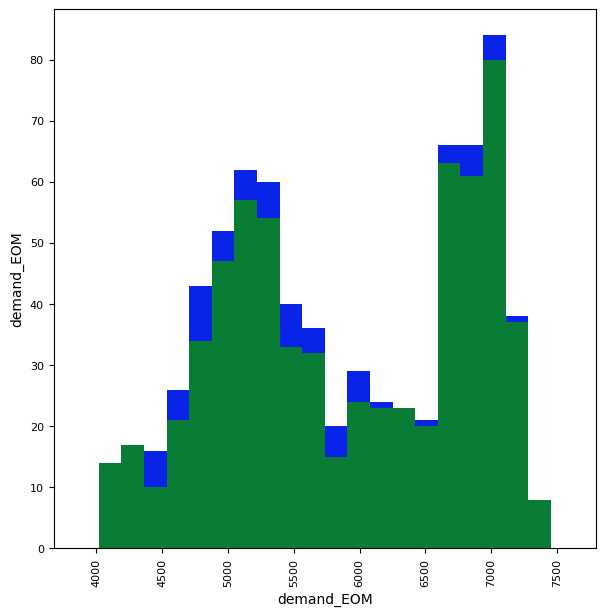

In [16]:
colors = list(["green"] * len(rest_demand_df)) + list(["blue"] * len(sample_demand_df))

# Scatter matrix
fig = pd.plotting.scatter_matrix(
    pd.concat([rest_demand_df, sample_demand_df], sort=False),
    c=colors,
    figsize=(7, 7),
    range_padding=0.2,
    hist_kwds={"bins": 20},  # Generic histogram configuration
    s=30,
    alpha=0.5,
)

# Customize histogram colors for each diagonal
hist_colors = ["green", "blue"]
for i, ax in enumerate(fig.diagonal()):
    data_combined = pd.concat([rest_demand_df.iloc[:, i], sample_demand_df.iloc[:, i]])
    ax.hist(
        [rest_demand_df.iloc[:, i], sample_demand_df.iloc[:, i]],
        bins=20,
        color=hist_colors,
        stacked=True,
        alpha=0.7,
    )

# Show plot
plt.show()

In [17]:
# scaler = StandardScaler()
# scaled_rest = scaler.fit_transform(rest_demand_df)
# scaled_sample = scaler.transform(sample_demand_df)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# tsne_results = tsne.fit_transform(np.append(scaled_rest, scaled_sample, axis=0))

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.7)
# plt.title("t-SNE Dimensionality Reduction")
# plt.xlabel("tSNE-1")
# plt.ylabel("tSNE-2")
# plt.show()

## 2.3 Bi-Level Optimisation 

In [18]:
from MPEC.bilevel_opt import find_optimal_dispatch
from MPEC.uc_problem import solve_uc_problem
from MPEC.utils import calculate_profits

### Defintion for case

In [19]:
case = "test_case"

big_w = 100000  # weight for duality gap objective
k_max = 2  # maximum multiplier for strategic bidding
opt_gen = 1  # generator index that is allowed to bid strategically

start = pd.to_datetime("2019-03-02 06:00")
end = pd.to_datetime("2019-03-02 14:00")

# gens
gens_df = pp_units.copy()

# 24 hours of demand first increasing and then decreasing
demand_df = sample_demand_df.copy()
demand_df.index = pd.to_datetime(demand_df.index)
demand_df = demand_df.loc[start:end]
# reset index to start at 0
demand_df = demand_df.reset_index(drop=True)
demand_df

,demand_EOM,date


## Input data transformation for Optimisation Problem 

In [20]:
# Transform gen_df into the format that is expected by the optimization problem
# g_max	mc	u_0	g_0	r_up	r_down	k_up	k_down
gens_df = gens_df.reset_index()
gens_df = gens_df.rename(columns={"max_power": "g_max", "min_power": "u_0"})
gens_df["r_up"] = gens_df["g_max"]  # ramping up constraints
gens_df["r_down"] = gens_df["g_max"]  # ramping down constraints
gens_df["k_up"] = 0  # start up costs
gens_df["k_down"] = 0  # shut down costs
gens_df["g_0"] = 0  # start with no power output

# get average mc from dispatch_df per unit name
mc = dispatch_df.groupby("unit")["energy_marginal_costs"].mean()

# based on name and unit column join mc into gens_df
gens_df = gens_df.merge(mc, left_on="name", right_on="unit", how="left")
gens_df = gens_df.rename(columns={"energy_marginal_costs": "mc"})
gens_df

,name,technology,bidding_EOM,fuel_type,emission_factor,g_max,u_0,efficiency,additional_cost,unit_operator,r_up,r_down,k_up,k_down,g_0,mc
0,pp_1,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1,1000,1000,0,0,0,12500.000000
1,pp_2,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1,1000,1000,0,0,0,12500.000000
2,pp_3,lignite,naive_eom,lignite,0.406,1000,1,0.41,2.0,Operator 1,1000,1000,0,0,0,31146.341463
3,pp_4,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1,1000,1000,0,0,0,32137.689628
4,pp_5,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1,1000,1000,0,0,0,32605.852238
5,pp_6,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,4795.340343
6,pp_7,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,12776.185156
7,pp_8,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,4419.290349
8,pp_9,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,9123.742884
9,pp_10,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,19359.590551


### Translate actions of RL model into k_values

In [21]:
# Merge on both 'unit_id' and 'time' columns
merged_df = sample_market_orders_df.merge(
    sample_dispatch_df.reset_index(),
    left_on=["unit_id", "start_time"],
    right_on=["unit", "time"],
    how="right",
)
merged_df

,end_time,price,volume,node,bid_id,unit_id,accepted_volume,accepted_price,market_id,bid_type,...,date_x,time,power,energy_cashflow,energy_marginal_costs,unit,simulation_y,total_costs,heat,date_y
0,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_1_1,pp_1,1000.0,36.15625,EOM,None,...,2019-03-16,2019-03-16 00:00:00,1000.0,36156.25000,1.250000e+04,pp_1,example_02b_base,NaN,0.0,2019-03-16
1,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_2_1,pp_2,1000.0,36.15625,EOM,None,...,2019-03-16,2019-03-16 00:00:00,1000.0,36156.25000,1.250000e+04,pp_2,example_02b_base,NaN,0.0,2019-03-16
2,2019-03-16 01:00:00.000000,31.146341,1000.0,node0,pp_3_1,pp_3,1000.0,36.15625,EOM,None,...,2019-03-16,2019-03-16 00:00:00,1000.0,36156.25000,3.114634e+04,pp_3,example_02b_base,NaN,0.0,2019-03-16
3,2019-03-16 01:00:00.000000,36.156250,1000.0,node0,pp_4_1,pp_4,1000.0,36.15625,EOM,None,...,2019-03-16,2019-03-16 00:00:00,1000.0,36156.25000,3.615625e+04,pp_4,example_02b_base,NaN,0.0,2019-03-16
4,2019-03-16 01:00:00.000000,36.156250,1000.0,node0,pp_5_1,pp_5,680.4,36.15625,EOM,None,...,2019-03-16,2019-03-16 00:00:00,680.4,24600.71250,2.460071e+04,pp_5,example_02b_base,NaN,0.0,2019-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,2019-03-31 00:00:00.000000,98.445572,499.0,node0,pp_9_2,pp_9,0.0,36.15625,EOM,None,...,2019-03-30,2019-03-30 23:00:00,1.0,36.15625,5.570833e+01,pp_9,example_02b_base,55.708333,0.0,2019-03-30
1220,2019-03-31 00:00:00.000000,-93.041069,1.0,node0,pp_10_1,pp_10,1.0,36.15625,EOM,None,...,2019-03-30,2019-03-30 23:00:00,500.0,18078.12500,2.785417e+04,pp_10,example_02b_base,27854.166667,0.0,2019-03-30
1221,2019-03-31 00:00:00.000000,-54.583679,499.0,node0,pp_10_2,pp_10,499.0,36.15625,EOM,None,...,2019-03-30,2019-03-30 23:00:00,500.0,18078.12500,2.785417e+04,pp_10,example_02b_base,27854.166667,0.0,2019-03-30
1222,2019-03-31 00:00:00.000000,85.708333,5000.0,node0,pp_11_1,pp_11,0.0,36.15625,EOM,None,...,2019-03-30,2019-03-30 23:00:00,0.0,0.00000,0.000000e+00,pp_11,example_02b_base,NaN,0.0,2019-03-30


In [ ]:
# TODO: how to translate the 2 actions per unit into one k_value? Currently:
# get max price per unit_id and date in the dataframe
id_k = merged_df.groupby(["unit_id", "time"])["price"].idxmax()
k_df = merged_df.loc[id_k]

# transformed actions into k_values, one per generator
k_df["k"] = k_df["price"] / (k_df["energy_marginal_costs"] * np.average(gens_df["mc"]))

# replace inf with 0
k_df["k"] = k_df["k"].replace(np.inf, 0)

k_values_df = k_df.pivot(index="time", columns="unit_id", values="k")
# k_values_df.reset_index(inplace=True)
k_values_df

unit_id,demand_EOM,pp_1,pp_10,pp_11,pp_2,pp_3,pp_4,pp_5,pp_6,pp_7,pp_8,pp_9
time,,,,,,,,,,,,
2019-03-16 00:00:00,1.132691e-08,5.867795e-08,3.578842e-08,0.000000,5.867795e-08,5.867795e-08,5.867795e-08,8.624037e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2019-03-16 01:00:00,1.187789e-08,5.867795e-08,5.387029e-08,0.000000,5.867795e-08,5.867795e-08,5.867795e-08,1.345516e-07,1.007022e-04,9.858826e-05,7.020371e-05,0.000104
2019-03-16 02:00:00,1.224830e-08,5.867795e-08,-2.974997e-08,0.000000,5.867795e-08,5.867795e-08,5.867795e-08,2.039553e-07,1.006703e-04,9.598477e-05,8.808203e-05,0.000000
2019-03-16 03:00:00,1.235533e-08,5.867795e-08,-6.155755e-08,0.000000,5.867795e-08,5.867795e-08,5.867795e-08,2.373703e-07,1.001497e-04,8.090821e-05,0.000000e+00,0.000000
2019-03-16 04:00:00,1.229656e-08,5.867795e-08,2.835421e-08,0.000000,5.867795e-08,5.867795e-08,2.182148e-07,5.867795e-08,9.790127e-05,4.652578e-05,0.000000e+00,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-30 19:00:00,1.060355e-08,5.867795e-08,9.376429e-05,0.000002,5.867795e-08,5.867795e-08,5.867795e-08,5.867795e-08,-1.690939e-07,9.143707e-05,9.586260e-05,0.000099
2019-03-30 20:00:00,1.114618e-08,5.867795e-08,9.550177e-05,0.000000,5.867795e-08,5.867795e-08,5.867795e-08,2.244757e-07,-1.254576e-07,5.355918e-08,6.918785e-05,0.000102
2019-03-30 21:00:00,1.186060e-08,5.867795e-08,9.024114e-05,0.000000,5.867795e-08,5.867795e-08,1.323662e-07,5.867795e-08,5.802850e-05,8.951362e-05,-5.889439e-09,0.000102


In [23]:
# drop demand_EOM column
# demand_df=demand_df.drop(columns=['demand_EOM'])

# sort columns to match the order of the columns in the gens_df
k_values_df = k_values_df[gens_df["name"].values]

# rename columns to match index of gens_df
k_values_df.columns = gens_df.index
k_values_df.reset_index(inplace=True)
k_values_df

,time,0,1,2,3,4,5,6,7,8,9,10
0,2019-03-16 00:00:00,0.001,0.001,0.001,0.001000,0.001470,0.000000,0.000000,0.000000,0.000000,0.000610,0.000000
1,2019-03-16 01:00:00,0.001,0.001,0.001,0.001000,0.002293,1.716185,1.680159,1.196424,1.767202,0.000918,0.000000
2,2019-03-16 02:00:00,0.001,0.001,0.001,0.001000,0.003476,1.715641,1.635789,1.501110,0.000000,-0.000507,0.000000
3,2019-03-16 03:00:00,0.001,0.001,0.001,0.001000,0.004045,1.706769,1.378852,0.000000,0.000000,-0.001049,0.000000
4,2019-03-16 04:00:00,0.001,0.001,0.001,0.003719,0.001000,1.668451,0.792901,0.000000,1.160166,0.000483,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-03-30 19:00:00,0.001,0.001,0.001,0.001000,0.001000,-0.002882,1.558287,1.633707,1.695085,1.597948,0.033557
68,2019-03-30 20:00:00,0.001,0.001,0.001,0.001000,0.003826,-0.002138,0.000913,1.179112,1.740278,1.627558,0.000000
69,2019-03-30 21:00:00,0.001,0.001,0.001,0.002256,0.001000,0.988932,1.525507,-0.000100,1.745410,1.537905,0.000000
70,2019-03-30 22:00:00,0.001,0.001,0.001,0.003511,0.001000,0.000000,0.000000,1.439728,1.763747,-0.000974,0.000000


### Join demand and price bid

In [24]:
# join sample demand df and sample market orders where unit id is demand_EOM based on index
sample_demand_df["price"] = sample_market_orders_df[
    sample_market_orders_df["unit_id"] == "demand_EOM"
]["price"]

# drop date column
sample_demand_df = sample_demand_df.drop(columns=["date"])

# rename index and columns
sample_demand_df.index.name = "datetime"
sample_demand_df.columns = ["volume", "price"]
demand_df = sample_demand_df.copy()
demand_df = demand_df.reset_index(drop=True)

C:\Users\AEppl\AppData\Local\Temp\ipykernel_28064\2809293092.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Run MPEC

In [25]:
print("We now optimize the decison for unit ", gens_df.index[opt_gen])

main_df, supp_df, k_values = find_optimal_dispatch(
    gens_df=gens_df,
    k_values_df=k_values_df,
    demand_df=demand_df,
    k_max=k_max,
    opt_gen=opt_gen,
    big_w=big_w,
    time_limit=3600,
    print_results=True,
    K=5,
    big_M=10e6,
)

# %%
# calculate actual market clearing prices
k_values_df_2 = k_values_df.copy()
k_values_df_2[opt_gen] = k_values

updated_main_df_2, updated_supp_df_2 = solve_uc_problem(
    gens_df, demand_df, k_values_df_2
)

# %%
# Calculate profits
profits_1 = calculate_profits(main_df=main_df, supp_df=supp_df, gens_df=gens_df)
profits_2 = calculate_profits(
    main_df=updated_main_df_2, supp_df=updated_supp_df_2, gens_df=gens_df
)

print(f"Estimated Profits: {profits_1[opt_gen].sum():.2f}")
print(f"True profits: {profits_2[opt_gen].sum():.2f}")

# in percentage
# print(
#    f"Profits difference: {100 * (profits_2[opt_gen].sum() - profits_1[opt_gen].sum()) / profits_1[opt_gen].sum():.2f}%"
# )

We now optimize the decison for unit  1
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 3600 --mipgap 0.03 --write C:\Users\AEppl\AppData\Local\Temp\tmp8hrq17at.glpk.raw
 --wglp C:\Users\AEppl\AppData\Local\Temp\tmps9oh0iko.glpk.glp --cpxlp C:\Users\AEppl\AppData\Local\Temp\tmpj3bj1y_g.pyomo.lp
Reading problem data from 'C:\Users\AEppl\AppData\Local\Temp\tmpj3bj1y_g.pyomo.lp'...
C:\Users\AEppl\AppData\Local\Temp\tmpj3bj1y_g.pyomo.lp:114452: warning: lower bound of variable 'x5475' redefined
C:\Users\AEppl\AppData\Local\Temp\tmpj3bj1y_g.pyomo.lp:114452: warning: upper bound of variable 'x5475' redefined
16344 rows, 14400 columns, 45538 non-zeros
3672 integer variables, all of which are binary
118124 lines were read
Writing problem data to 'C:\Users\AEppl\AppData\Local\Temp\tmps9oh0iko.glpk.glp'...
108325 lines were written
GLPK Integer Optimizer 5.0
16344 rows, 14400 columns, 45538 non-zeros
3672 integer variables, all of which are binary
Preprocessin

In [35]:
# TODO: Make plot that compares the profit of unit opt_gen from RL and MPEC
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Create index from 0 to 71
index = range(72)

# Create 5 power plant columns
columns = [f"pp_{i}" for i in range(1, 6)]

# Create random data between 200 and 300
df_rl = pd.DataFrame(
    np.random.uniform(200, 300, size=(72, 5)), index=index, columns=columns
)

df_mpec = pd.DataFrame(
    np.random.uniform(200, 300, size=(72, 5)), index=index, columns=columns
)

print("RL Profits:")
print(df_rl.head())
print("\nMPEC Profits:")
print(df_mpec.head())

RL Profits:
         pp_1        pp_2        pp_3        pp_4        pp_5
0  237.454012  295.071431  273.199394  259.865848  215.601864
1  215.599452  205.808361  286.617615  260.111501  270.807258
2  202.058449  296.990985  283.244264  221.233911  218.182497
3  218.340451  230.424224  252.475643  243.194502  229.122914
4  261.185289  213.949386  229.214465  236.636184  245.606998

MPEC Profits:
         pp_1        pp_2        pp_3        pp_4        pp_5
0  238.816993  264.328822  245.825289  254.561679  294.146481
1  238.610264  296.119056  290.535064  219.579113  206.936130
2  210.077800  201.822183  209.444296  268.300677  207.118865
3  231.897563  284.487531  202.327194  281.446848  228.185477
4  211.816483  269.673717  262.894285  287.747201  273.507104


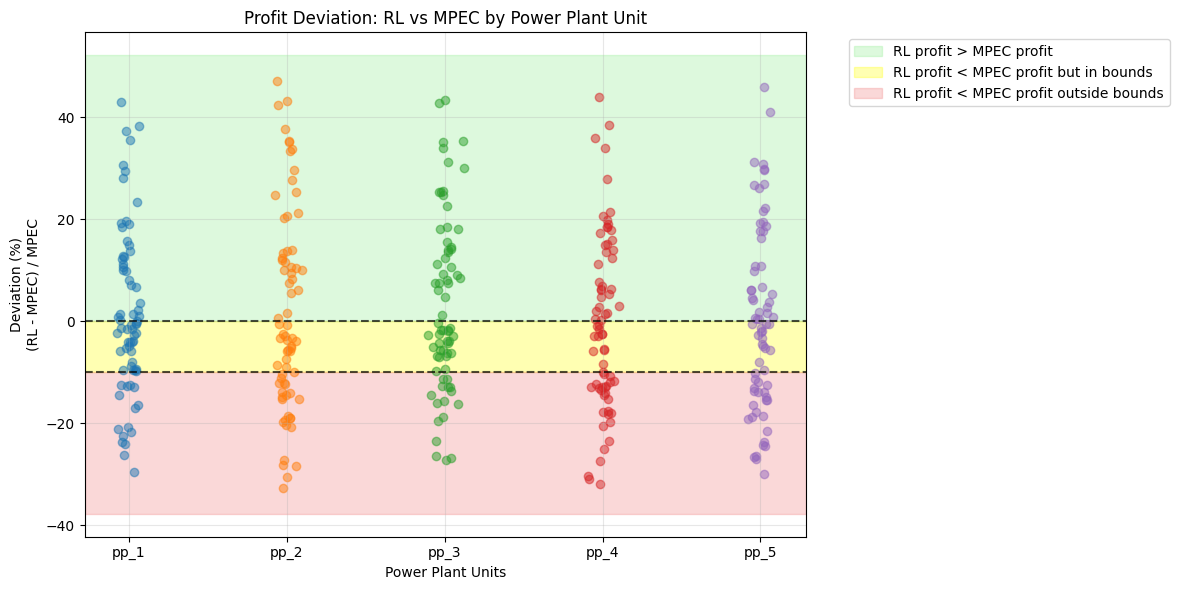

In [41]:
def create_profit_comparison_plot(df_rl, df_mpec, bound=-10):
    # Calculate percentage deviation
    percent_deviation = ((df_rl - df_mpec) / df_mpec) * 100

    # Get number of units (columns)
    n_units = len(df_rl.columns)

    # Create figure
    plt.figure(figsize=(12, 6))

    # Add horizontal lines at y=0 and y=bound
    plt.axhline(y=0, color="black", linestyle="--", alpha=0.7, linewidth=1.5)
    plt.axhline(y=bound, color="black", linestyle="--", alpha=0.7, linewidth=1.5)

    # Create background colors for different regions
    plt.axhspan(
        0,
        max(percent_deviation.max()) + 5,
        color="lightgreen",
        alpha=0.3,
        label="RL profit > MPEC profit",
    )
    plt.axhspan(
        bound,
        0,
        color="yellow",
        alpha=0.3,
        label="RL profit < MPEC profit but in bounds",
    )
    plt.axhspan(
        min(percent_deviation.min()) - 5,
        bound,
        color="lightcoral",
        alpha=0.3,
        label="RL profit < MPEC profit outside bounds",
    )

    # Create scatter plot for each unit
    for i, col in enumerate(df_rl.columns, 1):
        deviations = percent_deviation[col].values
        x = np.random.normal(i, 0.04, size=len(deviations))
        plt.scatter(x, deviations, alpha=0.5, label=None)

    # Customize plot
    plt.xlabel("Power Plant Units")
    plt.ylabel("Deviation (%)\n(RL - MPEC) / MPEC")
    plt.title("Profit Deviation: RL vs MPEC by Power Plant Unit")
    plt.grid(True, alpha=0.3)

    # Set x-ticks to unit numbers
    plt.xticks(range(1, n_units + 1), df_rl.columns)

    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()

    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout
    plt.tight_layout()

    return plt


fig = create_profit_comparison_plot(df_rl, df_mpec)
plt.show()

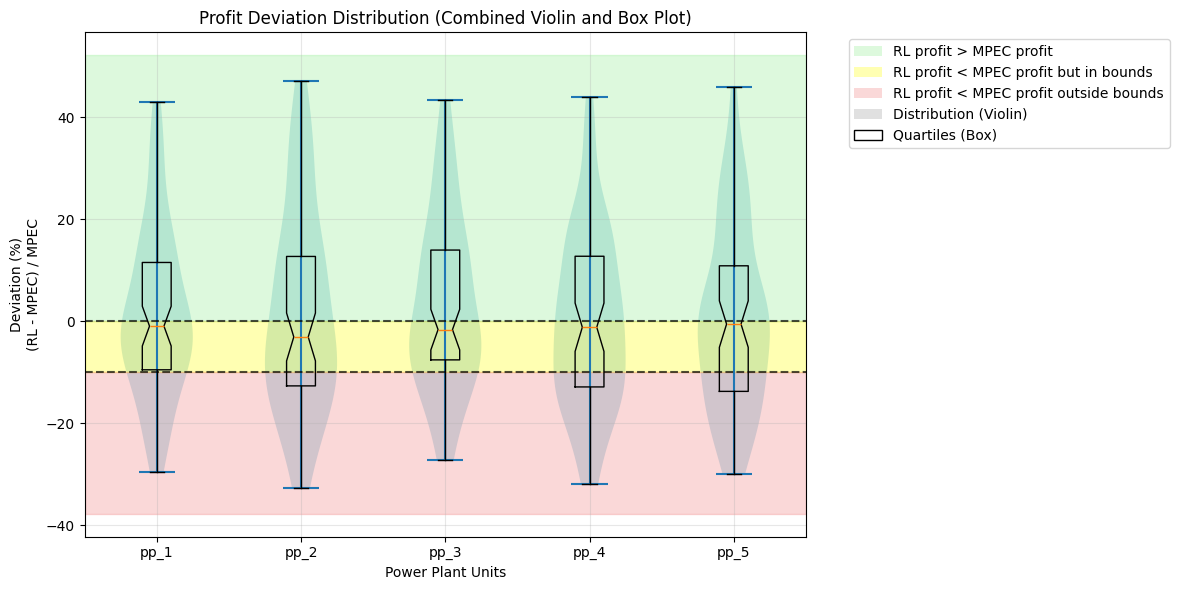

In [ ]:
def create_profit_comparison_plot(df_rl, df_mpec, bound=-10):
    # Calculate percentage deviation
    percent_deviation = ((df_rl - df_mpec) / df_mpec) * 100

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create violin plot
    parts = ax.violinplot(
        [percent_deviation[col].values for col in percent_deviation.columns],
        showmeans=False,
        showmedians=False,
    )

    # Customize violin plot colors
    for pc in parts["bodies"]:
        pc.set_facecolor("lightblue")
        pc.set_alpha(0.7)

    # Add box plot inside violin plot
    box_parts = ax.boxplot(
        [percent_deviation[col].values for col in percent_deviation.columns],
        positions=range(1, len(percent_deviation.columns) + 1),
        widths=0.2,
        showfliers=True,
        notch=True,
    )

    # Add horizontal lines and colored regions
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.7, linewidth=1.5)
    ax.axhline(y=bound, color="black", linestyle="--", alpha=0.7, linewidth=1.5)

    # Add colored regions
    ax.axhspan(0, max(percent_deviation.max()) + 5, color="lightgreen", alpha=0.3)
    ax.axhspan(bound, 0, color="yellow", alpha=0.3)
    ax.axhspan(min(percent_deviation.min()) - 5, bound, color="lightcoral", alpha=0.3)

    # Customize plot
    ax.set_xlabel("Power Plant Units")
    ax.set_ylabel("Deviation (%)\n(RL - MPEC) / MPEC")
    ax.set_title("Profit Deviation Distribution (Combined Violin and Box Plot)")
    ax.grid(True, alpha=0.3)

    # Set x-ticks
    ax.set_xticks(range(1, len(percent_deviation.columns) + 1))
    ax.set_xticklabels(percent_deviation.columns)

    # Add legend
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor="lightgreen",
            alpha=0.3,
            label="RL profit > MPEC profit",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor="yellow",
            alpha=0.3,
            label="RL profit < MPEC profit but in bounds",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor="lightcoral",
            alpha=0.3,
            label="RL profit < MPEC profit outside bounds",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor="lightblue",
            alpha=0.7,
            label="Distribution (Violin)",
        ),
        plt.Rectangle(
            (0, 0), 1, 1, facecolor="white", edgecolor="black", label="Quartiles (Box)"
        ),
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout
    plt.tight_layout()

    return fig


# Create and show the plot
fig = create_profit_comparison_plot(df_rl, df_mpec)
plt.show()